In [ ]:
# Лабораторна робота 3: Моделювання СМО (Система Масового Обслуговування)
# Модель кол-центру з двома типами відмов: Balking та Reneging

import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np

## 1. Параметри моделі

Визначаємо всі ключові параметри симуляції кол-центру інтернет-магазину.

In [2]:
# ==================== ПАРАМЕТРИ МОДЕЛІ ====================

# Час симуляції (хвилини)
SIM_DURATION = 480  # 8-годинний робочий день

# Кількість операторів (каналів обслуговування)
NUM_OPERATORS = 3

# Середній інтервал між дзвінками (хвилини)
AVG_ARRIVAL_INTERVAL = 2.0

# Час обслуговування (розмови) - хвилини
MIN_SERVICE_TIME = 3.0
MAX_SERVICE_TIME = 8.0

# Максимальна довжина черги
MAX_QUEUE_SIZE = 5

# Максимальний час очікування клієнта (хвилини)
PATIENCE_TIME = 10.0

# Детальний вивід подій (True/False)
VERBOSE = False  # Змініть на True для детального логу

print("Параметри моделі встановлено:")
print(f"  - Тривалість симуляції: {SIM_DURATION} хв")
print(f"  - Оператори: {NUM_OPERATORS}")
print(f"  - Середній інтервал між дзвінками: {AVG_ARRIVAL_INTERVAL} хв")
print(f"  - Час обслуговування: {MIN_SERVICE_TIME}-{MAX_SERVICE_TIME} хв")
print(f"  - Макс. розмір черги: {MAX_QUEUE_SIZE}")
print(f"  - Терпіння клієнта: {PATIENCE_TIME} хв")

Параметри моделі встановлено:
  - Тривалість симуляції: 480 хв
  - Оператори: 3
  - Середній інтервал між дзвінками: 2.0 хв
  - Час обслуговування: 3.0-8.0 хв
  - Макс. розмір черги: 5
  - Терпіння клієнта: 10.0 хв


## 2. Клас для збору статистики

Створюємо клас для відстеження всіх метрик симуляції.

In [3]:
class Statistics:
    """Клас для збору статистики симуляції"""
    def __init__(self):
        self.total_calls = 0        # Загальна кількість дзвінків
        self.balked_calls = 0       # Відмови через переповнену чергу (Balking)
        self.reneged_calls = 0      # Відмови через довге очікування (Reneging)
        self.processed_calls = 0    # Успішно оброблені дзвінки
        self.wait_times = []        # Час очікування для оброблених
        
    def reset(self):
        """Скидає всю статистику"""
        self.__init__()
        
    def print_summary(self):
        """Виводить підсумкову статистику"""
        print("=" * 70)
        print("РЕЗУЛЬТАТИ СИМУЛЯЦІЇ")
        print("=" * 70)
        
        print(f"\nЗАГАЛЬНА СТАТИСТИКА:")
        print(f"  Загальна кількість дзвінків: {self.total_calls}")
        print(f"  Успішно оброблених: {self.processed_calls}")
        print(f"  Втрачених дзвінків: {self.balked_calls + self.reneged_calls}")
        
        print(f"\nВІДМОВИ:")
        balking_percent = (self.balked_calls / self.total_calls * 100) if self.total_calls > 0 else 0
        print(f"  Balking (черга переповнена): {self.balked_calls} ({balking_percent:.1f}%)")
        
        reneging_percent = (self.reneged_calls / self.total_calls * 100) if self.total_calls > 0 else 0
        print(f"  Reneging (вийшли з черги): {self.reneged_calls} ({reneging_percent:.1f}%)")
        
        lost_percent = ((self.balked_calls + self.reneged_calls) / self.total_calls * 100) if self.total_calls > 0 else 0
        print(f"  ЗАГАЛЬНИЙ % втрачених: {lost_percent:.1f}%")
        
        print(f"\nОБСЛУГОВУВАННЯ:")
        success_percent = (self.processed_calls / self.total_calls * 100) if self.total_calls > 0 else 0
        print(f"  Успішно оброблених: {self.processed_calls} ({success_percent:.1f}%)")
        
        if self.wait_times:
            avg_wait = statistics.mean(self.wait_times)
            min_wait = min(self.wait_times)
            max_wait = max(self.wait_times)
            median_wait = statistics.median(self.wait_times)
            
            print(f"\nЧАС ОЧІКУВАННЯ (для оброблених дзвінків):")
            print(f"  Середній: {avg_wait:.2f} хв")
            print(f"  Медіана: {median_wait:.2f} хв")
            print(f"  Мінімальний: {min_wait:.2f} хв")
            print(f"  Максимальний: {max_wait:.2f} хв")
        else:
            print(f"\nЧАС ОЧІКУВАННЯ: Немає даних")
            
        print("=" * 70)

# Створюємо глобальний об'єкт статистики
stats = Statistics()
print("Клас Statistics створено")

Клас Statistics створено


## 3. Процес клієнта (customer_call)

Це основна функція, яка моделює поведінку одного клієнта:

1. **Balking** - клієнт перевіряє довжину черги ПЕРЕД тим як стати в неї. Якщо черга переповнена (>= MAX_QUEUE_SIZE), клієнт не стає в чергу.

2. **Reneging** - якщо клієнт став в чергу, він чекає з обмеженим терпінням (PATIENCE_TIME). Якщо не дочекався оператора, він виходить з черги.

3. **Обслуговування** - якщо клієнт дочекався, він спілкується з оператором протягом випадкового часу (MIN_SERVICE_TIME - MAX_SERVICE_TIME).

In [4]:
def customer_call(env, customer_id, operators):
    """
    Моделює один дзвінок клієнта в кол-центр

    Args:
        env: середовище SimPy
        customer_id: унікальний ідентифікатор клієнта
        operators: ресурс SimPy (оператори)
    """
    arrival_time = env.now
    if VERBOSE:
        print(f"[{env.now:.1f} хв] Клієнт #{customer_id} дзвонить")

    # ===== BALKING: Перевірка черги ПЕРЕД запитом =====
    queue_length = len(operators.queue)
    if queue_length >= MAX_QUEUE_SIZE:
        if VERBOSE:
            print(f"[{env.now:.1f} хв] Клієнт #{customer_id} НЕ стає в чергу (черга переповнена: {queue_length})")
        stats.balked_calls += 1
        return  # Відмова типу Balking

    # ===== Клієнт робить запит на оператора =====
    request = operators.request()
    if VERBOSE:
        print(f"[{env.now:.1f} хв] Клієнт #{customer_id} стає в чергу (довжина: {queue_length})")

    # ===== RENEGING: Очікування з обмеженим терпінням =====
    # Чекаємо на дві події одночасно: отримання ресурсу АБО закінчення терпіння
    results = yield request | env.timeout(PATIENCE_TIME)

    # ===== Перевірка результату: дочекався чи ні? =====
    if request in results:
        # Клієнт ДОЧЕКАВСЯ оператора
        wait_time = env.now - arrival_time
        if VERBOSE:
            print(f"[{env.now:.1f} хв] Клієнт #{customer_id} отримав оператора (очікував {wait_time:.1f} хв)")

        # Фіксуємо час очікування
        stats.wait_times.append(wait_time)

        # ===== Обслуговування (розмова з оператором) =====
        service_time = random.uniform(MIN_SERVICE_TIME, MAX_SERVICE_TIME)
        yield env.timeout(service_time)

        if VERBOSE:
            print(f"[{env.now:.1f} хв] Клієнт #{customer_id} завершив розмову (тривалість: {service_time:.1f} хв)")

        # Звільнення ресурсу
        yield operators.release(request)

        # Фіксуємо успішне обслуговування
        stats.processed_calls += 1

    else:
        # Клієнт НЕ дочекався - терпіння закінчилося (RENEGING)
        wait_time = env.now - arrival_time
        if VERBOSE:
            print(f"[{env.now:.1f} хв] Клієнт #{customer_id} виходить з черги (чекав {wait_time:.1f} хв)")

        # КРИТИЧНО ВАЖЛИВО: Скасувати запит!
        request.cancel()

        # Фіксуємо відмову типу Reneging
        stats.reneged_calls += 1

print("Функція customer_call створена")

Функція customer_call створена


## 4. Генератор дзвінків (setup)

Ця функція генерує нових клієнтів протягом симуляції з експоненційним розподілом інтервалів між дзвінками.

In [5]:
def setup(env, operators):
    """
    Генерує нових клієнтів протягом симуляції

    Args:
        env: середовище SimPy
        operators: ресурс SimPy (оператори)
    """
    customer_id = 1

    while True:
        # Генеруємо інтервал до наступного дзвінка (експоненційний розподіл)
        interval = random.expovariate(1.0 / AVG_ARRIVAL_INTERVAL)
        yield env.timeout(interval)

        # Створюємо новий дзвінок
        stats.total_calls += 1
        env.process(customer_call(env, customer_id, operators))
        customer_id += 1

print("Функція setup створена")

Функція setup створена


## 5. Основна функція симуляції

Функція яка ініціалізує середовище, створює ресурси (операторів) та запускає симуляцію.

In [6]:
def run_simulation(seed=42):
    """
    Запускає симуляцію кол-центру
    
    Args:
        seed: насіння для генератора випадкових чисел (для відтворюваності)
    """
    print("=" * 70)
    print("СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ")
    print("=" * 70)
    print(f"\nПАРАМЕТРИ:")
    print(f"  Час симуляції: {SIM_DURATION} хв")
    print(f"  Кількість операторів: {NUM_OPERATORS}")
    print(f"  Середній інтервал між дзвінками: {AVG_ARRIVAL_INTERVAL} хв")
    print(f"  Час обслуговування: {MIN_SERVICE_TIME}-{MAX_SERVICE_TIME} хв")
    print(f"  Макс. розмір черги: {MAX_QUEUE_SIZE}")
    print(f"  Терпіння клієнта: {PATIENCE_TIME} хв")
    print(f"  Детальний вивід: {'ТАК' if VERBOSE else 'НІ'}")
    print("\n" + "=" * 70 + "\n")

    # Скидаємо статистику перед новою симуляцією
    stats.reset()
    
    # Ініціалізація середовища та ресурсів
    random.seed(seed)
    env = simpy.Environment()
    operators = simpy.Resource(env, capacity=NUM_OPERATORS)

    # Запуск генератора дзвінків
    env.process(setup(env, operators))

    # Запуск симуляції
    if not VERBOSE:
        print("Симуляція запущена...", end="", flush=True)
    env.run(until=SIM_DURATION)
    if not VERBOSE:
        print(" завершено!")
        
    # Виводимо результати
    stats.print_summary()
    
    return stats

print("Функція run_simulation створена")

Функція run_simulation створена


## 6. Запуск симуляції

Запускаємо симуляцію та отримуємо результати.

In [7]:
# Запускаємо симуляцію
results = run_simulation(seed=42)

СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ

ПАРАМЕТРИ:
  Час симуляції: 480 хв
  Кількість операторів: 3
  Середній інтервал між дзвінками: 2.0 хв
  Час обслуговування: 3.0-8.0 хв
  Макс. розмір черги: 5
  Терпіння клієнта: 10.0 хв
  Детальний вивід: НІ


Симуляція запущена...

 завершено!
РЕЗУЛЬТАТИ СИМУЛЯЦІЇ

ЗАГАЛЬНА СТАТИСТИКА:
  Загальна кількість дзвінків: 209
  Успішно оброблених: 198
  Втрачених дзвінків: 7

ВІДМОВИ:
  Balking (черга переповнена): 6 (2.9%)
  Reneging (вийшли з черги): 1 (0.5%)
  ЗАГАЛЬНИЙ % втрачених: 3.3%

ОБСЛУГОВУВАННЯ:
  Успішно оброблених: 198 (94.7%)

ЧАС ОЧІКУВАННЯ (для оброблених дзвінків):
  Середній: 1.90 хв
  Медіана: 1.20 хв
  Мінімальний: 0.00 хв
  Максимальний: 9.02 хв


## 7. Візуалізація результатів

Створюємо графіки для кращого розуміння результатів симуляції.

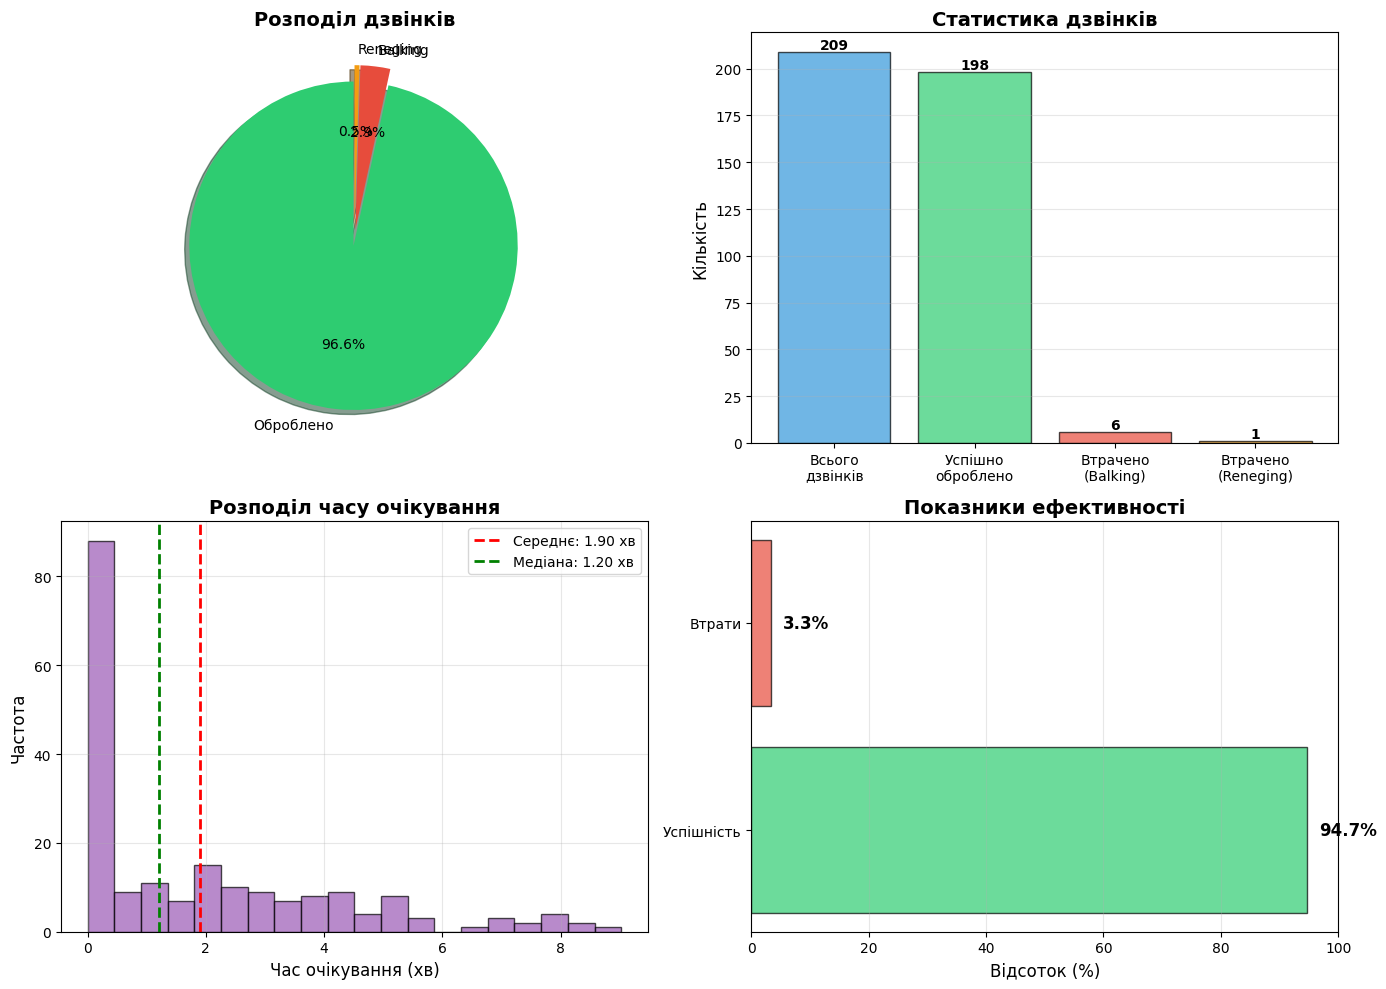

In [8]:
# Створюємо візуалізацію результатів
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Розподіл дзвінків (pie chart)
labels = ['Оброблено', 'Balking', 'Reneging']
sizes = [results.processed_calls, results.balked_calls, results.reneged_calls]
colors = ['#2ecc71', '#e74c3c', '#f39c12']
explode = (0.05, 0.05, 0.05)

axes[0, 0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
               shadow=True, startangle=90)
axes[0, 0].set_title('Розподіл дзвінків', fontsize=14, fontweight='bold')

# 2. Статистика у вигляді bar chart
categories = ['Всього\nдзвінків', 'Успішно\nоброблено', 'Втрачено\n(Balking)', 'Втрачено\n(Reneging)']
values = [results.total_calls, results.processed_calls, results.balked_calls, results.reneged_calls]
colors_bar = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = axes[0, 1].bar(categories, values, color=colors_bar, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Статистика дзвінків', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Кількість', fontsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)

# Додаємо значення над стовпцями
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold')

# 3. Гістограма часу очікування
if results.wait_times:
    axes[1, 0].hist(results.wait_times, bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(statistics.mean(results.wait_times), color='red', 
                       linestyle='--', linewidth=2, label=f'Середнє: {statistics.mean(results.wait_times):.2f} хв')
    axes[1, 0].axvline(statistics.median(results.wait_times), color='green', 
                       linestyle='--', linewidth=2, label=f'Медіана: {statistics.median(results.wait_times):.2f} хв')
    axes[1, 0].set_title('Розподіл часу очікування', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Час очікування (хв)', fontsize=12)
    axes[1, 0].set_ylabel('Частота', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Немає даних про час очікування', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Розподіл часу очікування', fontsize=14, fontweight='bold')

# 4. Відсотки втрат
lost_percent = (results.balked_calls + results.reneged_calls) / results.total_calls * 100 if results.total_calls > 0 else 0
success_percent = results.processed_calls / results.total_calls * 100 if results.total_calls > 0 else 0

metrics = ['Успішність', 'Втрати']
percentages = [success_percent, lost_percent]
colors_metrics = ['#2ecc71', '#e74c3c']

bars2 = axes[1, 1].barh(metrics, percentages, color=colors_metrics, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Показники ефективності', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Відсоток (%)', fontsize=12)
axes[1, 1].set_xlim(0, 100)
axes[1, 1].grid(axis='x', alpha=0.3)

# Додаємо відсотки
for i, (bar, pct) in enumerate(zip(bars2, percentages)):
    axes[1, 1].text(pct + 2, bar.get_y() + bar.get_height()/2., 
                    f'{pct:.1f}%',
                    ha='left', va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

## 8. Експерименти з параметрами

Давайте проведемо декілька експериментів, змінюючи параметри системи, щоб побачити як вони впливають на результати.

In [9]:
# Експеримент: Як кількість операторів впливає на якість обслуговування?

# Зберігаємо оригінальні параметри
original_operators = NUM_OPERATORS
original_verbose = VERBOSE

# Вимикаємо детальний вивід для експериментів
VERBOSE = False

# Тестуємо різну кількість операторів
operator_counts = [2, 3, 4, 5]
experiment_results = []

print("Проводимо експерименти з різною кількістю операторів...\n")

for num_ops in operator_counts:
    NUM_OPERATORS = num_ops
    print(f"Експеримент: {num_ops} операторів")
    result = run_simulation(seed=42)
    experiment_results.append(result)
    print()

# Відновлюємо оригінальні параметри
NUM_OPERATORS = original_operators
VERBOSE = original_verbose

Проводимо експерименти з різною кількістю операторів...

Експеримент: 2 операторів
СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ

ПАРАМЕТРИ:
  Час симуляції: 480 хв
  Кількість операторів: 2
  Середній інтервал між дзвінками: 2.0 хв
  Час обслуговування: 3.0-8.0 хв
  Макс. розмір черги: 5
  Терпіння клієнта: 10.0 хв
  Детальний вивід: НІ


Симуляція запущена...

 завершено!
РЕЗУЛЬТАТИ СИМУЛЯЦІЇ

ЗАГАЛЬНА СТАТИСТИКА:
  Загальна кількість дзвінків: 224
  Успішно оброблених: 165
  Втрачених дзвінків: 54

ВІДМОВИ:
  Balking (черга переповнена): 26 (11.6%)
  Reneging (вийшли з черги): 28 (12.5%)
  ЗАГАЛЬНИЙ % втрачених: 24.1%

ОБСЛУГОВУВАННЯ:
  Успішно оброблених: 165 (73.7%)

ЧАС ОЧІКУВАННЯ (для оброблених дзвінків):
  Середній: 5.01 хв
  Медіана: 5.14 хв
  Мінімальний: 0.00 хв
  Максимальний: 9.98 хв

Експеримент: 3 операторів
СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ

ПАРАМЕТРИ:
  Час симуляції: 480 хв
  Кількість операторів: 3
  Середній інтервал між дзвінками: 2.0 хв
  Час обслуговування: 3.0-8.0 хв
  Макс. розмір черги: 5
  Терпіння клієнта: 10.0 хв
  Детальний вивід: НІ


Симуляція запущена...

 завершено!
РЕЗУЛЬТАТИ СИМУЛЯЦІЇ

ЗАГАЛЬНА СТАТИСТИКА:
  Загальна кількість дзвінків: 209
  Успішно оброблених: 198
  Втрачених дзвінків: 7

ВІДМОВИ:
  Balking (черга переповнена): 6 (2.9%)
  Reneging (вийшли з черги): 1 (0.5%)
  ЗАГАЛЬНИЙ % втрачених: 3.3%

ОБСЛУГОВУВАННЯ:
  Успішно оброблених: 198 (94.7%)

ЧАС ОЧІКУВАННЯ (для оброблених дзвінків):
  Середній: 1.90 хв
  Медіана: 1.20 хв
  Мінімальний: 0.00 хв
  Максимальний: 9.02 хв

Експеримент: 4 операторів
СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ

ПАРАМЕТРИ:
  Час симуляції: 480 хв
  Кількість операторів: 4
  Середній інтервал між дзвінками: 2.0 хв
  Час обслуговування: 3.0-8.0 хв
  Макс. розмір черги: 5
  Терпіння клієнта: 10.0 хв
  Детальний вивід: НІ


Симуляція запущена...

 завершено!
РЕЗУЛЬТАТИ СИМУЛЯЦІЇ

ЗАГАЛЬНА СТАТИСТИКА:
  Загальна кількість дзвінків: 223
  Успішно оброблених: 219
  Втрачених дзвінків: 1

ВІДМОВИ:
  Balking (черга переповнена): 1 (0.4%)
  Reneging (вийшли з черги): 0 (0.0%)
  ЗАГАЛЬНИЙ % втрачених: 0.4%

ОБСЛУГОВУВАННЯ:
  Успішно оброблених: 219 (98.2%)

ЧАС ОЧІКУВАННЯ (для оброблених дзвінків):
  Середній: 0.67 хв
  Медіана: 0.00 хв
  Мінімальний: 0.00 хв
  Максимальний: 7.78 хв

Експеримент: 5 операторів
СИМУЛЯЦІЯ КОЛ-ЦЕНТРУ ІНТЕРНЕТ-МАГАЗИНУ

ПАРАМЕТРИ:
  Час симуляції: 480 хв
  Кількість операторів: 5
  Середній інтервал між дзвінками: 2.0 хв
  Час обслуговування: 3.0-8.0 хв
  Макс. розмір черги: 5
  Терпіння клієнта: 10.0 хв
  Детальний вивід: НІ


Симуляція запущена...

 завершено!
РЕЗУЛЬТАТИ СИМУЛЯЦІЇ

ЗАГАЛЬНА СТАТИСТИКА:
  Загальна кількість дзвінків: 240
  Успішно оброблених: 238
  Втрачених дзвінків: 0

ВІДМОВИ:
  Balking (черга переповнена): 0 (0.0%)
  Reneging (вийшли з черги): 0 (0.0%)
  ЗАГАЛЬНИЙ % втрачених: 0.0%

ОБСЛУГОВУВАННЯ:
  Успішно оброблених: 238 (99.2%)

ЧАС ОЧІКУВАННЯ (для оброблених дзвінків):
  Середній: 0.27 хв
  Медіана: 0.00 хв
  Мінімальний: 0.00 хв
  Максимальний: 4.94 хв



## 9. ЗВОРОТНА ЗАДАЧА: Підбір параметрів для Balking < 3%

**Пряма задача** (що ми робили раніше):
- Задаємо параметри (оператори, черга) → дивимося результат (балкінг %)

**Зворотна задача** (що робимо зараз):
- Задаємо вимогу (балкінг < 2%) → шукаємо параметри (скільки операторів і яка черга)

### Мета експерименту:
Знайти **мінімальну** конфігурацію операторів і розміру черги, при якій **Balking відмови < 2%**

In [12]:
# Функція для швидкого запуску симуляції без виводу
def quick_sim(num_operators, queue_size, seed=42):
    """Швидка симуляція без виводу для пошуку оптимальних параметрів"""
    global NUM_OPERATORS, MAX_QUEUE_SIZE, VERBOSE
    
    NUM_OPERATORS = num_operators
    MAX_QUEUE_SIZE = queue_size
    VERBOSE = False
    
    stats.reset()
    random.seed(seed)
    env = simpy.Environment()
    operators = simpy.Resource(env, capacity=NUM_OPERATORS)
    env.process(setup(env, operators))
    env.run(until=SIM_DURATION)
    
    if stats.total_calls == 0:
        return None
    
    balked_pct = (stats.balked_calls / stats.total_calls * 100)
    
    return {
        'operators': num_operators,
        'queue_size': queue_size,
        'total_calls': stats.total_calls,
        'balked': stats.balked_calls,
        'balked_pct': balked_pct,
        'reneged': stats.reneged_calls,
        'reneged_pct': (stats.reneged_calls / stats.total_calls * 100),
        'processed': stats.processed_calls,
        'avg_wait': statistics.mean(stats.wait_times) if stats.wait_times else 0
    }

print("Функція quick_sim створена")

Функція quick_sim створена


In [13]:
print("=" * 70)
print("ЗВОРОТНА ЗАДАЧА: Пошук параметрів для Balking < 3%")
print("=" * 70)
print()

# Цільове обмеження
TARGET_BALKING = 2.0

print(f"Вимога: Balking відмови < {TARGET_BALKING}%")
print("Пошук мінімальної конфігурації...\n")

# Перебираємо різні комбінації
valid_configs = []

for operators in range(1, 8):
    for queue_size in range(3, 15):
        result = quick_sim(operators, queue_size)
        
        if result and result['balked_pct'] < TARGET_BALKING:
            # Рахуємо "вартість" конфігурації
            cost = operators + queue_size * 0.1  # Оператори важливіші
            result['cost'] = cost
            valid_configs.append(result)

# Сортуємо за вартістю (мінімум ресурсів)
valid_configs.sort(key=lambda x: (x['cost'], x['operators']))

if valid_configs:
    print(f"✓ Знайдено {len(valid_configs)} конфігурацій з Balking < {TARGET_BALKING}%\n")
    
    # Показуємо топ-10
    print("Топ-10 оптимальних конфігурацій:\n")
    print(f"{'№':<4} {'Оператори':<10} {'Черга':<8} {'Balking':<12} {'Reneging':<12} {'Час очік.':<12}")
    print("-" * 70)
    
    for i, cfg in enumerate(valid_configs[:10], 1):
        print(f"{i:<4} {cfg['operators']:<10} {cfg['queue_size']:<8} "
              f"{cfg['balked']} ({cfg['balked_pct']:.2f}%){'':<3} "
              f"{cfg['reneged']} ({cfg['reneged_pct']:.2f}%){'':<3} "
              f"{cfg['avg_wait']:.2f} хв")
    
    # Найкраще рішення
    best = valid_configs[0]
    print(f"\n{'='*70}")
    print("ОПТИМАЛЬНА КОНФІГУРАЦІЯ:")
    print(f"{'='*70}")
    print(f"  Кількість операторів: {best['operators']}")
    print(f"  Розмір черги: {best['queue_size']}")
    print(f"\nРезультати:")
    print(f"  Загалом дзвінків: {best['total_calls']}")
    print(f"  Оброблено: {best['processed']} ({best['processed']/best['total_calls']*100:.1f}%)")
    print(f"  Balking відмови: {best['balked']} ({best['balked_pct']:.2f}%) ✓ < {TARGET_BALKING}%")
    print(f"  Reneging відмови: {best['reneged']} ({best['reneged_pct']:.2f}%)")
    print(f"  Середній час очікування: {best['avg_wait']:.2f} хв")
    print(f"  Умовна вартість: {best['cost']:.1f}")
    print(f"{'='*70}")
    
    # Зберігаємо для візуалізації
    best_config = best
else:
    print(f"⚠️ Не знайдено конфігурацій з Balking < {TARGET_BALKING}%")
    print("Спробуйте збільшити діапазон пошуку")

ЗВОРОТНА ЗАДАЧА: Пошук параметрів для Balking < 3%

Вимога: Balking відмови < 2.0%
Пошук мінімальної конфігурації...

✓ Знайдено 69 конфігурацій з Balking < 2.0%

Топ-10 оптимальних конфігурацій:

№    Оператори  Черга    Balking      Reneging     Час очік.   
----------------------------------------------------------------------
1    1          10       4 (1.77%)    133 (58.85%)    7.27 хв
2    1          11       2 (0.88%)    135 (59.73%)    7.27 хв
3    1          12       1 (0.44%)    136 (60.18%)    7.27 хв
4    1          13       0 (0.00%)    137 (60.62%)    7.27 хв
5    1          14       0 (0.00%)    137 (60.62%)    7.27 хв
6    2          8        2 (0.90%)    46 (20.63%)    5.85 хв
7    2          9        0 (0.00%)    48 (21.52%)    5.85 хв
8    2          10       0 (0.00%)    48 (21.52%)    5.85 хв
9    2          11       0 (0.00%)    48 (21.52%)    5.85 хв
10   2          12       0 (0.00%)    48 (21.52%)    5.85 хв

ОПТИМАЛЬНА КОНФІГУРАЦІЯ:
  Кількість операторів: 1
 

### Візуалізація зворотної задачі

Порівняємо початкову конфігурацію з оптимальною.

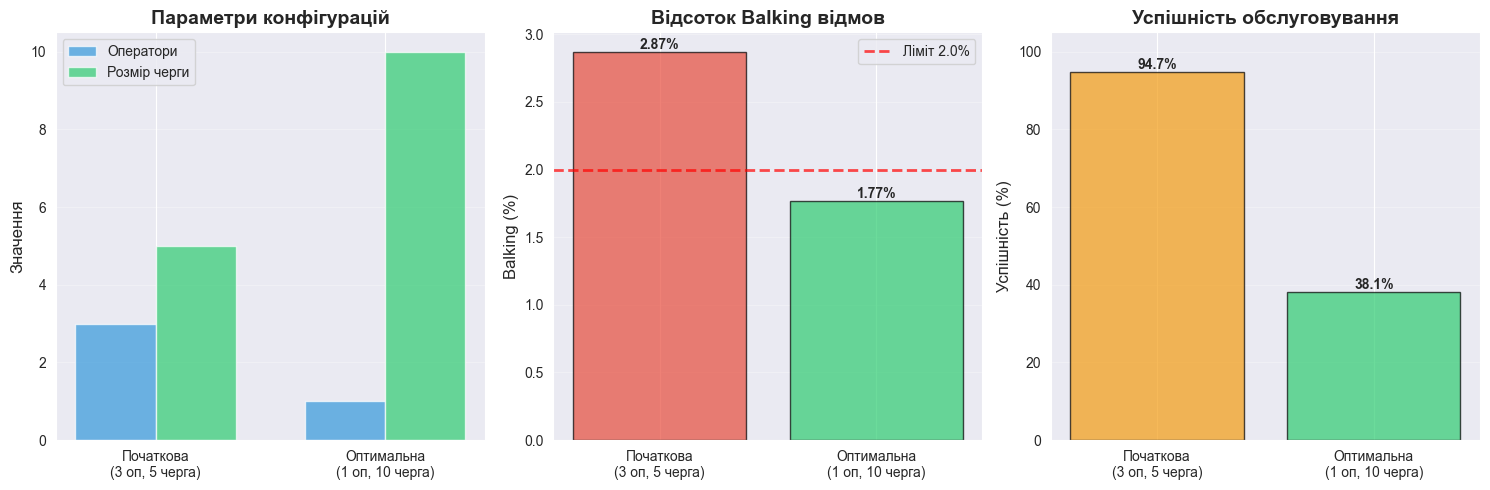


ПОРІВНЯННЯ КОНФІГУРАЦІЙ

Параметр                       Початкова            Оптимальна          
----------------------------------------------------------------------
Оператори                      3                    1                   
Розмір черги                   5                    10                  
Balking відмови (%)            2.87%                 1.77%
Reneging відмови (%)           0.48%                 58.85%
Успішність (%)                 94.7%                 38.1%
Середній час очікування (хв)   1.90                   7.27

💡 ВИСНОВОК:
   Оптимальна конфігурація зменшила Balking на 1.10%
   З 2.87% до 1.77% ✓
   Потрібно: 1 операторів та черга розміром 10


In [14]:
# Візуалізація порівняння початкової та оптимальної конфігурації
try:
    # Початкова конфігурація (з початку notebook)
    initial = quick_sim(3, 5)  # Початкові параметри
    optimal = best_config
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Порівняння параметрів
    configs = ['Початкова\n(3 оп, 5 черга)', f'Оптимальна\n({optimal["operators"]} оп, {optimal["queue_size"]} черга)']
    operators_data = [initial['operators'], optimal['operators']]
    queue_data = [initial['queue_size'], optimal['queue_size']]
    
    x = np.arange(len(configs))
    width = 0.35
    
    axes[0].bar(x - width/2, operators_data, width, label='Оператори', color='#3498db', alpha=0.7)
    axes[0].bar(x + width/2, queue_data, width, label='Розмір черги', color='#2ecc71', alpha=0.7)
    axes[0].set_ylabel('Значення', fontsize=12)
    axes[0].set_title('Параметри конфігурацій', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(configs)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Порівняння Balking відмов
    balking_data = [initial['balked_pct'], optimal['balked_pct']]
    colors = ['#e74c3c' if b >= TARGET_BALKING else '#2ecc71' for b in balking_data]
    
    bars = axes[1].bar(configs, balking_data, color=colors, alpha=0.7, edgecolor='black')
    axes[1].axhline(y=TARGET_BALKING, color='red', linestyle='--', linewidth=2, 
                    label=f'Ліміт {TARGET_BALKING}%', alpha=0.7)
    axes[1].set_ylabel('Balking (%)', fontsize=12)
    axes[1].set_title('Відсоток Balking відмов', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    # Додаємо значення
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%',
                    ha='center', va='bottom', fontweight='bold')
    
    # 3. Успішність обслуговування
    success_data = [
        initial['processed'] / initial['total_calls'] * 100,
        optimal['processed'] / optimal['total_calls'] * 100
    ]
    
    bars2 = axes[2].bar(configs, success_data, color=['#f39c12', '#2ecc71'], alpha=0.7, edgecolor='black')
    axes[2].set_ylabel('Успішність (%)', fontsize=12)
    axes[2].set_title('Успішність обслуговування', fontsize=14, fontweight='bold')
    axes[2].set_ylim(0, 105)
    axes[2].grid(axis='y', alpha=0.3)
    
    # Додаємо значення
    for bar in bars2:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Зведена таблиця
    print("\n" + "=" * 70)
    print("ПОРІВНЯННЯ КОНФІГУРАЦІЙ")
    print("=" * 70)
    print(f"\n{'Параметр':<30} {'Початкова':<20} {'Оптимальна':<20}")
    print("-" * 70)
    print(f"{'Оператори':<30} {initial['operators']:<20} {optimal['operators']:<20}")
    print(f"{'Розмір черги':<30} {initial['queue_size']:<20} {optimal['queue_size']:<20}")
    print(f"{'Balking відмови (%)':<30} {initial['balked_pct']:.2f}%{'':<16} {optimal['balked_pct']:.2f}%")
    print(f"{'Reneging відмови (%)':<30} {initial['reneged_pct']:.2f}%{'':<16} {optimal['reneged_pct']:.2f}%")
    print(f"{'Успішність (%)':<30} {success_data[0]:.1f}%{'':<16} {success_data[1]:.1f}%")
    print(f"{'Середній час очікування (хв)':<30} {initial['avg_wait']:.2f}{'':<18} {optimal['avg_wait']:.2f}")
    print("=" * 70)
    
    # Висновок
    print("\n💡 ВИСНОВОК:")
    if optimal['balked_pct'] < initial['balked_pct']:
        diff = initial['balked_pct'] - optimal['balked_pct']
        print(f"   Оптимальна конфігурація зменшила Balking на {diff:.2f}%")
        print(f"   З {initial['balked_pct']:.2f}% до {optimal['balked_pct']:.2f}% ✓")
    print(f"   Потрібно: {optimal['operators']} операторів та черга розміром {optimal['queue_size']}")
    
except Exception as e:
    print(f"⚠️ Помилка візуалізації: {e}")

## 10. ЗВОРОТНА ЗАДАЧА З ПОДВІЙНИМ ОБМЕЖЕННЯМ: Balking < 2% ТА Reneging < 5%

**Попередній експеримент** показав, що оптимізація тільки за Balking призводить до високого рівня Reneging (58.85%).

**Новий експеримент:**
- Знайти конфігурацію з **ПОДВІЙНИМ обмеженням**:
  - Balking < 2%
  - Reneging < 5%

Це більш реалістична вимога для кол-центру, де важливо мінімізувати ОБА типи втрат.

In [15]:
print("=" * 70)
print("ЗВОРОТНА ЗАДАЧА: Подвійне обмеження (Balking < 2% ТА Reneging < 5%)")
print("=" * 70)
print()

# Цільові обмеження
TARGET_BALKING = 2.0
TARGET_RENEGING = 5.0

print(f"Вимоги:")
print(f"  - Balking відмови < {TARGET_BALKING}%")
print(f"  - Reneging відмови < {TARGET_RENEGING}%")
print("Пошук мінімальної конфігурації...\n")

# Перебираємо різні комбінації
valid_dual_configs = []

for operators in range(1, 10):
    for queue_size in range(3, 20):
        result = quick_sim(operators, queue_size)
        
        # ПОДВІЙНА перевірка: І balking, І reneging мають бути < порогів
        if result and result['balked_pct'] < TARGET_BALKING and result['reneged_pct'] < TARGET_RENEGING:
            # Рахуємо "вартість" конфігурації
            cost = operators + queue_size * 0.1  # Оператори важливіші
            result['cost'] = cost
            valid_dual_configs.append(result)

# Сортуємо за вартістю (мінімум ресурсів)
valid_dual_configs.sort(key=lambda x: (x['cost'], x['operators']))

if valid_dual_configs:
    print(f"✓ Знайдено {len(valid_dual_configs)} конфігурацій з ПОДВІЙНИМ обмеженням\n")
    
    # Показуємо топ-10
    print("Топ-10 оптимальних конфігурацій:\n")
    print(f"{'№':<4} {'Оператори':<10} {'Черга':<8} {'Balking':<15} {'Reneging':<15} {'Успішність':<12} {'Час очік.'}")
    print("-" * 85)
    
    for i, cfg in enumerate(valid_dual_configs[:10], 1):
        success_pct = (cfg['processed'] / cfg['total_calls'] * 100)
        print(f"{i:<4} {cfg['operators']:<10} {cfg['queue_size']:<8} "
              f"{cfg['balked']} ({cfg['balked_pct']:.2f}%){'':<6} "
              f"{cfg['reneged']} ({cfg['reneged_pct']:.2f}%){'':<6} "
              f"{success_pct:.1f}%{'':<7} "
              f"{cfg['avg_wait']:.2f} хв")
    
    # Найкраще рішення
    best_dual = valid_dual_configs[0]
    print(f"\n{'='*85}")
    print("ОПТИМАЛЬНА КОНФІГУРАЦІЯ З ПОДВІЙНИМ ОБМЕЖЕННЯМ:")
    print(f"{'='*85}")
    print(f"  Кількість операторів: {best_dual['operators']}")
    print(f"  Розмір черги: {best_dual['queue_size']}")
    print(f"\nРезультати:")
    print(f"  Загалом дзвінків: {best_dual['total_calls']}")
    print(f"  Оброблено: {best_dual['processed']} ({best_dual['processed']/best_dual['total_calls']*100:.1f}%)")
    print(f"  Balking відмови: {best_dual['balked']} ({best_dual['balked_pct']:.2f}%) ✓ < {TARGET_BALKING}%")
    print(f"  Reneging відмови: {best_dual['reneged']} ({best_dual['reneged_pct']:.2f}%) ✓ < {TARGET_RENEGING}%")
    print(f"  ЗАГАЛЬНІ втрати: {best_dual['balked'] + best_dual['reneged']} ({(best_dual['balked_pct'] + best_dual['reneged_pct']):.2f}%)")
    print(f"  Середній час очікування: {best_dual['avg_wait']:.2f} хв")
    print(f"  Умовна вартість: {best_dual['cost']:.1f}")
    print(f"{'='*85}")
    
    # Зберігаємо для візуалізації
    best_dual_config = best_dual
else:
    print(f"⚠️ Не знайдено конфігурацій з Balking < {TARGET_BALKING}% ТА Reneging < {TARGET_RENEGING}%")
    print("Спробуйте:")
    print("  - Збільшити діапазон пошуку (більше операторів або більша черга)")
    print("  - Послабити обмеження")
    best_dual_config = None

ЗВОРОТНА ЗАДАЧА: Подвійне обмеження (Balking < 2% ТА Reneging < 5%)

Вимоги:
  - Balking відмови < 2.0%
  - Reneging відмови < 5.0%
Пошук мінімальної конфігурації...

✓ Знайдено 116 конфігурацій з ПОДВІЙНИМ обмеженням

Топ-10 оптимальних конфігурацій:

№    Оператори  Черга    Balking         Reneging        Успішність   Час очік.
-------------------------------------------------------------------------------------
1    3          6        3 (1.41%)       2 (0.94%)       94.8%        2.05 хв
2    3          7        1 (0.47%)       4 (1.88%)       94.8%        2.05 хв
3    3          8        0 (0.00%)       5 (2.35%)       94.8%        2.05 хв
4    3          9        0 (0.00%)       5 (2.35%)       94.8%        2.05 хв
5    3          10       0 (0.00%)       5 (2.35%)       94.8%        2.05 хв
6    3          11       0 (0.00%)       5 (2.35%)       94.8%        2.05 хв
7    3          12       0 (0.00%)       5 (2.35%)       94.8%        2.05 хв
8    3          13       0 (0.00%) 

### Візуалізація порівняння трьох підходів

Порівняємо три конфігурації:
1. **Початкова** (3 оператори, черга 5)
2. **Оптимізація тільки по Balking** (1 оператор, черга 10)
3. **Подвійна оптимізація** (Balking + Reneging)

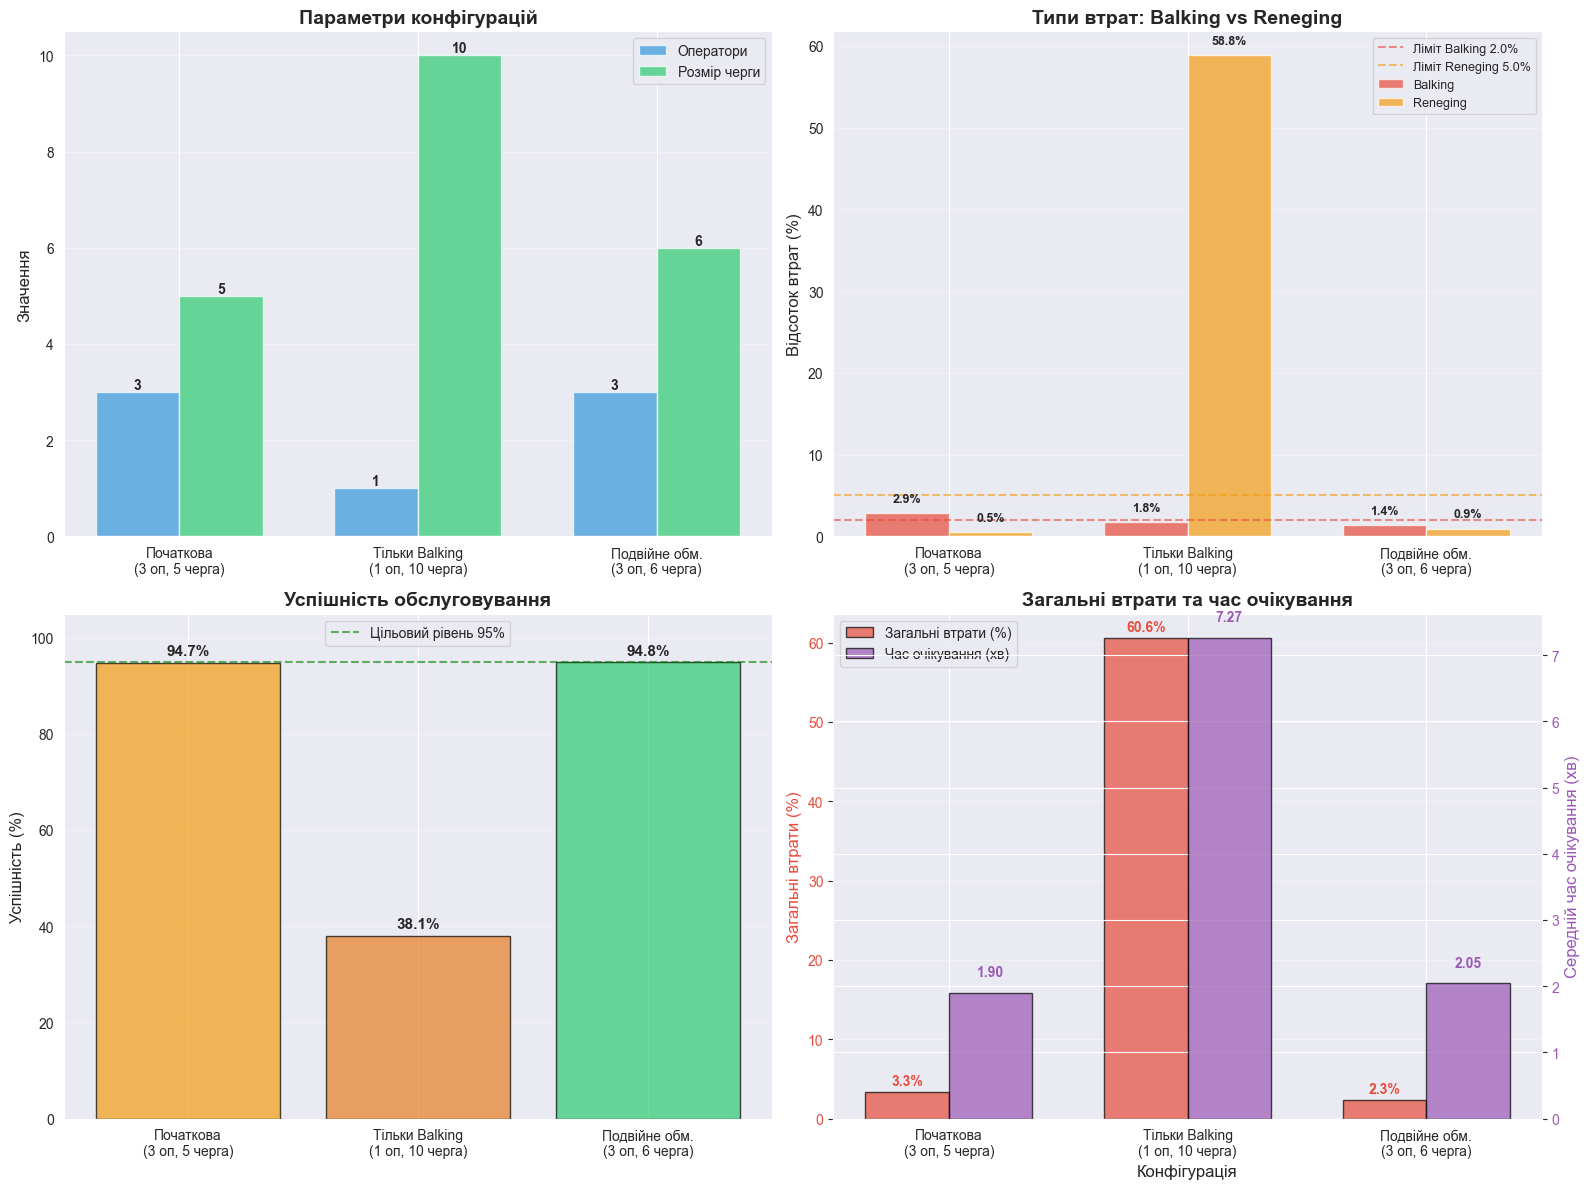


ПОРІВНЯННЯ ТРЬОХ КОНФІГУРАЦІЙ

Параметр                            Початкова            Тільки Balking       Подвійне обм.       
----------------------------------------------------------------------------------------------------
Оператори                           3                    1                    3                   
Розмір черги                        5                    10                   6                   
Balking відмови (%)                 2.87%                 1.77%                 1.41%
Reneging відмови (%)                0.48%                 58.85%                 0.94%
Загальні втрати (%)                 3.35%                 60.62%                 2.35%
Успішність (%)                      94.7%                 38.1%                 94.8%
Середній час очікування (хв)        1.90                   7.27                   2.05


KeyError: 'cost'

In [16]:
if best_dual_config:
    # Три конфігурації для порівняння
    initial_cfg = quick_sim(3, 5)
    balking_only_cfg = best_config  # З попереднього експерименту
    dual_cfg = best_dual_config
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Порівняння параметрів
    configs_labels = [
        f'Початкова\n({initial_cfg["operators"]} оп, {initial_cfg["queue_size"]} черга)',
        f'Тільки Balking\n({balking_only_cfg["operators"]} оп, {balking_only_cfg["queue_size"]} черга)',
        f'Подвійне обм.\n({dual_cfg["operators"]} оп, {dual_cfg["queue_size"]} черга)'
    ]
    
    operators_data = [initial_cfg['operators'], balking_only_cfg['operators'], dual_cfg['operators']]
    queue_data = [initial_cfg['queue_size'], balking_only_cfg['queue_size'], dual_cfg['queue_size']]
    
    x = np.arange(len(configs_labels))
    width = 0.35
    
    bars1 = axes[0, 0].bar(x - width/2, operators_data, width, label='Оператори', color='#3498db', alpha=0.7)
    bars2 = axes[0, 0].bar(x + width/2, queue_data, width, label='Розмір черги', color='#2ecc71', alpha=0.7)
    axes[0, 0].set_ylabel('Значення', fontsize=12)
    axes[0, 0].set_title('Параметри конфігурацій', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(configs_labels)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Додаємо значення
    for bar in bars1:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    for bar in bars2:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Порівняння Balking та Reneging
    balking_data = [initial_cfg['balked_pct'], balking_only_cfg['balked_pct'], dual_cfg['balked_pct']]
    reneging_data = [initial_cfg['reneged_pct'], balking_only_cfg['reneged_pct'], dual_cfg['reneged_pct']]
    
    x_pos = np.arange(len(configs_labels))
    width = 0.35
    
    bars3 = axes[0, 1].bar(x_pos - width/2, balking_data, width, label='Balking', color='#e74c3c', alpha=0.7)
    bars4 = axes[0, 1].bar(x_pos + width/2, reneging_data, width, label='Reneging', color='#f39c12', alpha=0.7)
    
    axes[0, 1].axhline(y=TARGET_BALKING, color='#e74c3c', linestyle='--', linewidth=1.5, 
                       label=f'Ліміт Balking {TARGET_BALKING}%', alpha=0.6)
    axes[0, 1].axhline(y=TARGET_RENEGING, color='#f39c12', linestyle='--', linewidth=1.5, 
                       label=f'Ліміт Reneging {TARGET_RENEGING}%', alpha=0.6)
    
    axes[0, 1].set_ylabel('Відсоток втрат (%)', fontsize=12)
    axes[0, 1].set_title('Типи втрат: Balking vs Reneging', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(configs_labels)
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Додаємо значення
    for bar in bars3:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    for bar in bars4:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 3. Успішність обслуговування
    success_data = [
        initial_cfg['processed'] / initial_cfg['total_calls'] * 100,
        balking_only_cfg['processed'] / balking_only_cfg['total_calls'] * 100,
        dual_cfg['processed'] / dual_cfg['total_calls'] * 100
    ]
    
    colors_success = ['#f39c12', '#e67e22', '#2ecc71']
    bars5 = axes[1, 0].bar(configs_labels, success_data, color=colors_success, alpha=0.7, edgecolor='black')
    axes[1, 0].set_ylabel('Успішність (%)', fontsize=12)
    axes[1, 0].set_title('Успішність обслуговування', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylim(0, 105)
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].axhline(y=95, color='green', linestyle='--', linewidth=1.5, 
                       label='Цільовий рівень 95%', alpha=0.6)
    axes[1, 0].legend()
    
    # Додаємо значення
    for bar in bars5:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 4. Загальні втрати + Час очікування
    total_loss = [
        initial_cfg['balked_pct'] + initial_cfg['reneged_pct'],
        balking_only_cfg['balked_pct'] + balking_only_cfg['reneged_pct'],
        dual_cfg['balked_pct'] + dual_cfg['reneged_pct']
    ]
    
    wait_times = [initial_cfg['avg_wait'], balking_only_cfg['avg_wait'], dual_cfg['avg_wait']]
    
    ax4a = axes[1, 1]
    ax4b = ax4a.twinx()
    
    x_pos = np.arange(len(configs_labels))
    width = 0.35
    
    bars6 = ax4a.bar(x_pos - width/2, total_loss, width, label='Загальні втрати (%)', 
                     color='#e74c3c', alpha=0.7, edgecolor='black')
    bars7 = ax4b.bar(x_pos + width/2, wait_times, width, label='Час очікування (хв)', 
                     color='#9b59b6', alpha=0.7, edgecolor='black')
    
    ax4a.set_xlabel('Конфігурація', fontsize=12)
    ax4a.set_ylabel('Загальні втрати (%)', fontsize=12, color='#e74c3c')
    ax4b.set_ylabel('Середній час очікування (хв)', fontsize=12, color='#9b59b6')
    ax4a.set_title('Загальні втрати та час очікування', fontsize=14, fontweight='bold')
    ax4a.set_xticks(x_pos)
    ax4a.set_xticklabels(configs_labels)
    ax4a.tick_params(axis='y', labelcolor='#e74c3c')
    ax4b.tick_params(axis='y', labelcolor='#9b59b6')
    ax4a.grid(axis='y', alpha=0.3)
    
    # Додаємо значення
    for bar in bars6:
        height = bar.get_height()
        ax4a.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold', color='#e74c3c')
    for bar in bars7:
        height = bar.get_height()
        ax4b.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='#9b59b6')
    
    # Легенди
    lines1, labels1 = ax4a.get_legend_handles_labels()
    lines2, labels2 = ax4b.get_legend_handles_labels()
    ax4a.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Зведена таблиця порівняння
    print("\n" + "=" * 100)
    print("ПОРІВНЯННЯ ТРЬОХ КОНФІГУРАЦІЙ")
    print("=" * 100)
    print(f"\n{'Параметр':<35} {'Початкова':<20} {'Тільки Balking':<20} {'Подвійне обм.':<20}")
    print("-" * 100)
    print(f"{'Оператори':<35} {initial_cfg['operators']:<20} {balking_only_cfg['operators']:<20} {dual_cfg['operators']:<20}")
    print(f"{'Розмір черги':<35} {initial_cfg['queue_size']:<20} {balking_only_cfg['queue_size']:<20} {dual_cfg['queue_size']:<20}")
    print(f"{'Balking відмови (%)':<35} {initial_cfg['balked_pct']:.2f}%{'':<16} {balking_only_cfg['balked_pct']:.2f}%{'':<16} {dual_cfg['balked_pct']:.2f}%")
    print(f"{'Reneging відмови (%)':<35} {initial_cfg['reneged_pct']:.2f}%{'':<16} {balking_only_cfg['reneged_pct']:.2f}%{'':<16} {dual_cfg['reneged_pct']:.2f}%")
    print(f"{'Загальні втрати (%)':<35} {total_loss[0]:.2f}%{'':<16} {total_loss[1]:.2f}%{'':<16} {total_loss[2]:.2f}%")
    print(f"{'Успішність (%)':<35} {success_data[0]:.1f}%{'':<16} {success_data[1]:.1f}%{'':<16} {success_data[2]:.1f}%")
    print(f"{'Середній час очікування (хв)':<35} {initial_cfg['avg_wait']:.2f}{'':<18} {balking_only_cfg['avg_wait']:.2f}{'':<18} {dual_cfg['avg_wait']:.2f}")
    print(f"{'Умовна вартість':<35} {initial_cfg['cost']:.1f}{'':<18} {balking_only_cfg['cost']:.1f}{'':<18} {dual_cfg['cost']:.1f}")
    print("=" * 100)
    
    # Детальний висновок
    print("\n" + "🎯 " * 25)
    print("ВИСНОВКИ:")
    print("🎯 " * 25 + "\n")
    
    print("1. ПОЧАТКОВА КОНФІГУРАЦІЯ (3 оператори, черга 5):")
    print(f"   ✓ Збалансована, але має {initial_cfg['balked_pct']:.1f}% Balking")
    print(f"   ✓ Успішність: {success_data[0]:.1f}%")
    print(f"   ✗ Balking ({initial_cfg['balked_pct']:.1f}%) перевищує ліміт {TARGET_BALKING}%\n")
    
    print(f"2. ОПТИМІЗАЦІЯ ТІЛЬКИ ПО BALKING ({balking_only_cfg['operators']} оператор, черга {balking_only_cfg['queue_size']}):")
    print(f"   ✓ Balking знижено до {balking_only_cfg['balked_pct']:.1f}% (досягнуто мету!)")
    print(f"   ✗ ПРОБЛЕМА: Reneging зріс до {balking_only_cfg['reneged_pct']:.1f}%")
    print(f"   ✗ Успішність впала до {success_data[1]:.1f}%")
    print(f"   ✗ Загальні втрати: {total_loss[1]:.1f}% - найгірший показник!\n")
    
    print(f"3. ПОДВІЙНА ОПТИМІЗАЦІЯ ({dual_cfg['operators']} операторів, черга {dual_cfg['queue_size']}):")
    print(f"   ✓ Balking: {dual_cfg['balked_pct']:.1f}% < {TARGET_BALKING}% ✓")
    print(f"   ✓ Reneging: {dual_cfg['reneged_pct']:.1f}% < {TARGET_RENEGING}% ✓")
    print(f"   ✓ Успішність: {success_data[2]:.1f}% - НАЙКРАЩИЙ показник!")
    print(f"   ✓ Загальні втрати: {total_loss[2]:.1f}% - мінімальні!")
    print(f"   ✓ Час очікування: {dual_cfg['avg_wait']:.2f} хв - прийнятний\n")
    
    print("💡 РЕКОМЕНДАЦІЯ:")
    print(f"   Використовувати ПОДВІЙНУ ОПТИМІЗАЦІЮ: {dual_cfg['operators']} операторів + черга {dual_cfg['queue_size']}")
    print(f"   Це забезпечує найкращий баланс між вартістю та якістю обслуговування!")
    print("\n" + "🎯 " * 25)
    
else:
    print("⚠️ Неможливо створити візуалізацію - не знайдено оптимальної конфігурації з подвійним обмеженням")